# A Simple System For Single Digit Recognition In Speech

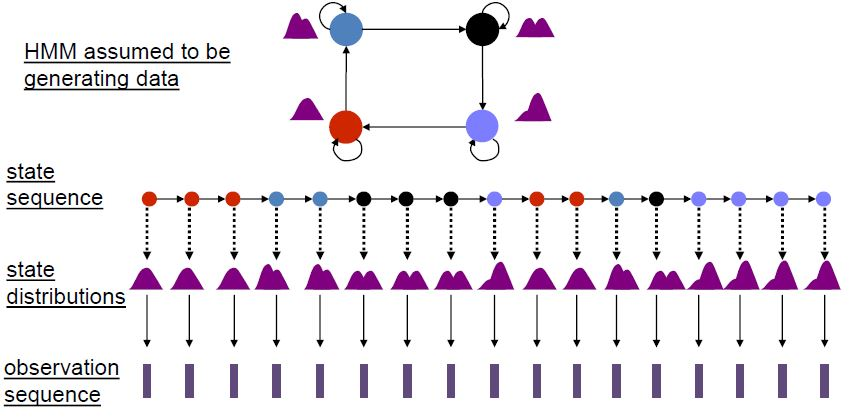
It is common to model the human speeching process using a Hidden Markov Model(HMM). The structure shown in the figure is a generic representation of a statistical model for processes that generate time series. A HMM model consists of two components: a state backbone that specifies how many states in the model and how they transist to one another; different probability distributions for each state. Since we can only observe the time-varying series we need an algorithm to estimate the parameters for distributions in each state and also the transistion probability between states.

## Import Necessary Libraries

In [1]:
import os
import numpy as np
from scipy.io import wavfile
from scikits.talkbox.features import mfcc
#from sklearn.mixture import GaussianMixture as GMM

## Define The HMM Model For Single Digit

Every state in our HMM model is represented by a different Gaussian Mixture Model (GMM) and for simplicity we only implement a single Gaussian distribution for each state here (KMeans). Since speech is a left to right process and some sounds may occasionally be skipped, we use the Bakis topology as the state backbone.
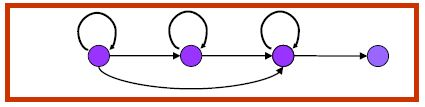
We estimate parameters in the HMM models with an iterative process which is known as Viterbi Training, a combination of Dynamic Time Warping (DTW) with transition penalty. With this algorithm we can divide frames into several segments(states) and estimate the possible distribution repectively.
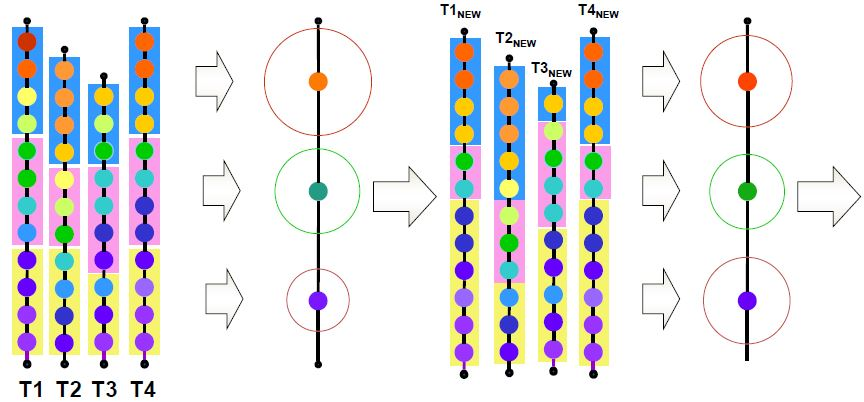
The general training process is shown in the above figure. The model is initialized by uniform segmentation of the frame series. Then align each template to the averaged model to get new segmentations and recompute the average model from new segmentations. The whole procedure converges when the total best-alignment error for all training sequences does not change significantly (in this code we actually compare the absolute difference of each state between two iterations and use this deviation to determine whether convergence is reached or not).
In order to due with varying segment lengths, we use transition probability between each state to account for the natural differences in segment length. The larger this probability is, the more possible the corresponding transition will happen (less penalty). We can compute transition probabilities just simply by counting.
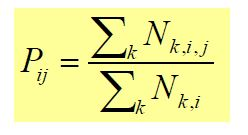
N(k,i) is the number of frames/vectors in segment(state) i of the training sample k and N(k,i,j) is the number of frames/vectors in segment(state) i of the training sample k that were followed by vectors/frames from segment(state) j.

After obtaining template for each digit, we can build a trellis with 'observation probabilities' (how likely a given input is generated by a specific distribution) as its node scores and transition probabilities as its edge cost. Note that to avoid underflow, we use loglikelihood as scores and sum them up along 'paths' in the trellis to mind the probability of most likely state sequence. It is easy to know that if s_x is followed by s_y, the best path to s_y through s_x is just an extension of the best path to s_x. By applyting the Viterbi algorithm we can obtain an estimate of the state sequence followed in producing the observation and the probability of the best state sequence. By comparing probabilities obtained by models representing different digits and selecting the one with highest probabiliy, we can achieve the purpose of digit recognition.
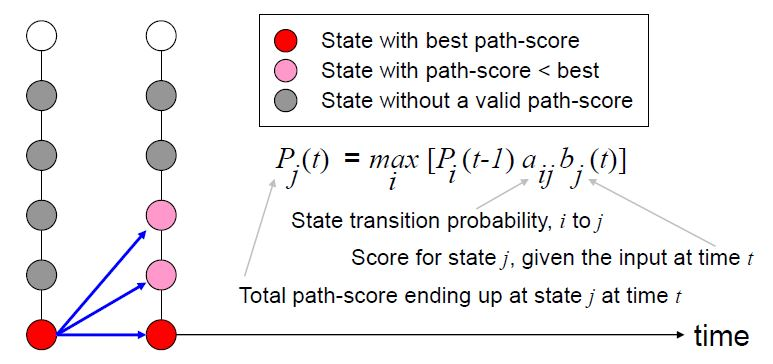

In [2]:
# Define templates for each digits

unseenProb = 0.00001 # Small probability for possible unseen transition
not_computed = -10**5 # Value that indicates the node in trellis has not been computed

class singleDigitHMM(object):
    
    def __init__(self, digit, input_feature, nstates, dev):
        
        super(singleDigitHMM, self).__init__()
        self.digit = digit
        self.feature = input_feature
        self.dev = dev
        self.nstates = nstates
        self.means = np.zeros((nstates, 13))
        self.std = np.zeros((nstates, 13))
        self.transPro = self.initTransPro(input_feature)
        self.initStates()
        
    def initTransPro(self, input_feature):
        
        # Approximated by counting the number of frames followed by frames from the next state
        transPro = np.ones((4,self.nstates+1))*unseenProb # [staying, next state, skip next state, totall]
        segment = 0
        for f in input_feature:
            segment += f.shape[0] / self.nstates
        
        # dummy state
        transPro[1, 0] = 1
        
        transPro[1, 1:-1] = 1.0*len(input_feature)/segment
        transPro[0, 1:-1] = 1 - 1.0*len(input_feature)/segment
        
        # finally state
        transPro[0, -1] = 1
        
        return transPro
        
    # Equivalent to computing log( P(x|m_i) )
    def logLikelihood(self, x, i):
        
        s = np.log(2*np.pi*self.std[i,:]**2)
        s += (1.0*(x-self.means[i,:])/self.std[i,:])**2
        return -0.5*np.sum(s)
        
        
    def initStates(self):
        
        for i in range(self.nstates):
             # Stack all frames to form the training set to train the GMM of state(i)
            segment = self.feature[0].shape[0] / self.nstates
            X = self.feature[0][i*segment:(i+1)*segment, :]
            for j in range(1, len(self.feature)):
                segment = self.feature[j].shape[0] / self.nstates
                X = np.row_stack((X, self.feature[j][i*segment:(i+1)*segment, :]))
            self.means[i] = np.mean(X, axis = 0)
            self.std[i] = np.std(X, axis = 0)
        
    # Viterbi Training to Estimate Model's Parameters 
    def train(self):
        
        count = np.zeros((4,self.nstates+1)) # [staying, next state, skip next state, totall]
        X = [ [] for i in range(self.nstates)]
        for f in self.feature:
            prev_s = -1 # Dummy state at the beginning
            for i in range(f.shape[0]):

                # Self-loop
                if prev_s < 0:
                    prob = np.log(unseenProb)
                else:
                    prob = self.logLikelihood(f[i,:], prev_s) + np.log(self.transPro[0, prev_s+1])
                cur_s = prev_s

                # First couple states are allowed to skip one state
                if prev_s < self.nstates-2:
                    p = self.logLikelihood(f[i,:], prev_s+2) + np.log(self.transPro[2, prev_s+1])
                    if p > prob:
                        prob = p
                        cur_s = prev_s+2

                # States except the last one can either stay or move to the next one
                if prev_s < self.nstates-1:
                    p = self.logLikelihood(f[i,:], prev_s+1) + np.log(self.transPro[1, prev_s+1])
                    if p > prob:
                        prob = p
                        cur_s = prev_s+1

                count[cur_s-prev_s][prev_s+1] += 1
                count[-1][prev_s+1] += 1
                
                prev_s = cur_s
                if len(X[prev_s]) == 0:
                    X[prev_s] = f[i,:]
                else:
                    X[prev_s] = np.row_stack((X[prev_s], f[i,:]))
            
            if len(X[prev_s]) == 0:
                    X[prev_s] = f[-1,:]
            else:
                X[prev_s] = np.row_stack((X[prev_s], f[-1,:]))
        
        self.transPro = 1.0*count[:-1,:]/count[-1,:]+unseenProb # Recompute the transition probabilities


        # Recompute the average model and look at the deviation of each centroid
        new_means = np.zeros((self.nstates, 13))
        new_std = np.zeros((self.nstates, 13))
        dev = 0
        for i in range(self.nstates):
            new_means[i, :] = np.mean(X[i], axis = 0)
            new_std[i, :] = np.std(X[i], axis = 0)
            dev += np.sum(np.abs(new_means[i,:]-self.means[i,:]))
        
        # Keep iterating if it is not converged
        if dev > self.dev:
            self.means = new_means
            self.std = new_std
            self.train()

    # Predict the Probability of A Given Sequence Generated by the Model ( Viterbi Algorithm )        
    def predict(self, feature):
        
        trellis = np.ones((self.nstates, feature.shape[0])) * not_computed
        trellis[0, 0] = self.logLikelihood(feature[0,:], 0) + np.log(self.transPro[1, 0])
        
        # Allow to skip the first state to account for possible silence
        trellis[1, 0] = self.logLikelihood(feature[0,:], 1) + np.log(self.transPro[2, 0])
        
        for idx_f in range(1, feature.shape[0]):
            for idx_m in range(self.nstates):
                
                # Stay in the same state
                best_score = trellis[idx_m, idx_f-1] + np.log(self.transPro[0, idx_m+1])
                
                # Move to the next state
                if idx_m > 1:
                    ns = trellis[idx_m-1,idx_f-1]+np.log(self.transPro[1,idx_m])
                    best_score = (ns > best_score) and ns or best_score
                    
                # Skip one state
                if idx_m > 2:
                    ns = trellis[idx_m-2,idx_f-1]+np.log(self.transPro[1,idx_m-1])
                    best_score = (ns > best_score) and ns or best_score
                    
                trellis[idx_m, idx_f] = best_score + self.logLikelihood(feature[idx_f,:], idx_m)
        
        return np.max(trellis[-2:,-1])

## Load Training Dataset

The dataset is loaded using a transcript file, which contains words for digits being spoken in the audio file specified by the name at the end of each line. There is also slience (marked as 'sil') at the beginning and end of each audio input. The training samples in the dataset have varying length and we only use samples of single digits for training. Notice that 0s are both spoken as 'zero' and 'oh'. Therefore we need to construct two separated models for the digit. Here is how the transcript file looks like.
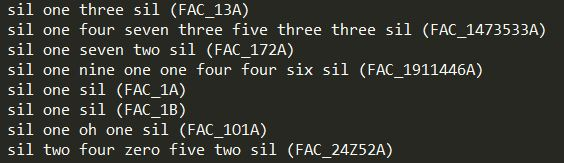

In [3]:
# Define the code book for converting words to digits
codebook = {'one':1, 'two':2, 'three':3, 
'four':4, 'five':5, 'six':6, 'seven':7, 
'eight':8, 'nine':9, 'zero':10, 'oh':0, 'sil':-1}


# Function to convert words to digits
def Str2Dig(words):

    digits = []
    for w in words:
        digits.append(codebook[w])
    return digits


# Load training set and compute mfcc features for each sample
DATASET = 'dataset'
LIST_TRAIN = os.path.join(DATASET, 'TRAIN.transcripts')
TRAIN = os.path.join(DATASET, 'train')

t = 20 # 20 ms for each frame
features_train = []
digits_train = []
idx_single_digit_train = [[] for i in range(11)]

i = 0
with open(LIST_TRAIN, 'r') as f:
    for line in f:
        line = line.strip()
        s = line.split()
        d = Str2Dig(s[:-1])
        if len(d) == 3: # For simplicity we only consider single digit input here
            idx_single_digit_train[d[1]].append(i)
            digits_train.append(d[1])
            fs, x = wavfile.read(os.path.join(TRAIN, s[-1][1:-1]+'.wav'))
            feature = mfcc(x, nwin = int(fs*t/1000), fs = fs, nceps = 13)[0]
            features_train.append(feature)
            i += 1
        
l_train = [len(i) for i in idx_single_digit_train]
print('Number of training samples for each digit (0~10):')
print(l_train)

Number of training samples for each digit (0~10):
[216, 220, 220, 220, 220, 220, 220, 220, 220, 220, 216]


## Load Testing Dataset

In [4]:
# Load testing set and compute mfcc features for each sample
LIST_TEST = os.path.join(DATASET, 'TEST.transcripts')
TEST = os.path.join(DATASET, 'test')

t = 20 # 20 ms for each frame
features_test = []
digits_test = []
idx_single_digit_test = [[] for i in range(11)]

i = 0
with open(LIST_TEST, 'r') as f:
    for line in f:
        line = line.strip()
        s = line.split()
        d = Str2Dig(s[:-1])
        if len(d) == 1: # For simplicity we only consider single digit input here
            idx_single_digit_test[d[0]].append(i)
            digits_test.append(d)
            fs, x = wavfile.read(os.path.join(TEST, s[-1][1:-1]+'.wav'))
            feature = mfcc(x, nwin = int(fs*t/1000), fs = fs, nceps = 13)[0]
            features_test.append(feature)
            i += 1
        
l_test = [len(i) for i in idx_single_digit_test]
print('Number of testing samples for each digit (0~10):')
print(l_test)


Number of testing samples for each digit (0~10):
[30, 27, 30, 27, 26, 29, 24, 22, 24, 29, 29]


## Build And Train Models For Different Digits

In [5]:
# Construct models and train them using the training set
models = []
for idx in range(11):
    hmm = singleDigitHMM(idx, [features_train[i] for i in idx_single_digit_train[idx]], 7, 0.1)
    hmm.train()
    models.append(hmm)
    
# Compute accuracy on the training samples
digits_train_pred = []
for f in features_train:
    best_pred = models[0].predict(f)
    d = models[0].digit
    for i in range(1, 11):
        pred = models[i].predict(f)
        if pred > best_pred:
            best_pred = pred
            d = models[i].digit
    digits_train_pred.append(d)
    
acc = np.mean(np.array(digits_train_pred) == np.array(digits_train))
print("Accuracy on training dataset: {:.3f}".format(acc))

Accuracy on training dataset: 0.894


## Perform Validation On Testing Dataset

In [6]:
digits_test_pred = []
for f in features_test:
    best_pred = models[0].predict(f)
    d = models[0].digit
    for i in range(1, 11):
        pred = models[i].predict(f)
        if pred > best_pred:
            best_pred = pred
            d = models[i].digit
    digits_test_pred.append(d)

val_acc = np.mean(np.array(digits_test_pred) == np.array(digits_test))
print("Accuracy on testing dataset: {:.3f}".format(val_acc))

Accuracy on testing dataset: 0.092


## Results Analysis

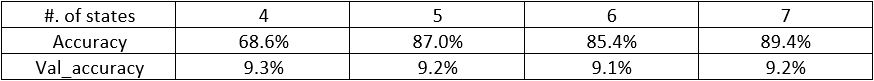

Since we don't know the actual number of states for each digit, we could only try different values and see which one gives us the best result. As we can see, although the model has reached almost 90% accuracy on the training set by increasing the number of states from 3 to be 7, the validation accuracy of the testing set does not improve. There might be lots of reasons causing this but the major one is that, the model is not trained on a dataset that is large enough. So over-fitting happens and the model is not able capture the common characteristics that represent different digits.